# **I wrote this program to count a certain type of vehicles from a real traffic footage video that I recorded as a part of my research. This program is created to count the number of vehicles (buses or all vehicles) passing through a drawn line in a video. I used a YOLO model to detect vehicles in each frame of the video.**

In [1]:
!nvidia-smi

Mon May 26 16:23:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


to get a path of a source video

In [ ]:
  #on googlecolab (example)
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/cropped 24.mp4"
  #on kaggle (example)
#SOURCE_VIDEO_PATH = f"{HOME}/00024.mp4"

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 32.3/235.7 GB disk)


In [ ]:
!pip install supervision --upgrade

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


In [ ]:
from ultralytics import YOLO
#yolo model is used to detect vehicles in the video
#model = YOLO(MODEL)

a yolo model is trained to detect buses on kaggle

In [ ]:
#model training
#!yolo task=detect mode=train model=yolov8x.pt data=/kaggle/input/busclassonly/data.yaml epochs=100 imgsz=640 save_period=100

In [ ]:
# Load the trained model (best weights saved during training)
#model1 = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [ ]:
# Validate the model
#model1.val(data='/kaggle/input/busclassonly/data.yaml')

saved a trained model as a "bus only model" in drive

In [ ]:
#We used a 'bus only model' trained on a dataset containing bus annotations, to detect and count only buses in the video
model = YOLO("/content/drive/MyDrive/bus only model/best.pt")

In [ ]:
import os

json_data = '''{
"settings_version": "0.0.6",
"datasets_dir": "/kaggle/working/datasets",
"weights_dir": "weights",
"runs_dir": "runs",
"uuid": "1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff",
"sync": true,
"api_key": "",
"openai_api_key": "",
"clearml": true,
"comet": true,
"dvc": true,
"hub": true,
"mlflow": true,
"neptune": true,
"raytune": true,
"tensorboard": true,
"wandb": false,
"vscode_msg": true
}'''

with open('/root/.config/Ultralytics/settings.json', 'w') as file:
    file.write(json_data)


In [ ]:
!cat /root/.config/Ultralytics/settings.json

{
"settings_version": "0.0.6",
"datasets_dir": "/kaggle/working/datasets",
"weights_dir": "weights",
"runs_dir": "runs",
"uuid": "1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff",
"sync": true,
"api_key": "",
"openai_api_key": "",
"clearml": true,
"comet": true,
"dvc": true,
"hub": true,
"mlflow": true,
"neptune": true,
"raytune": true,
"tensorboard": true,
"wandb": false,
"vscode_msg": true
}

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

{0: 'car', 1: 'bus', 2: 'truck'}


In [ ]:
# class_ids of interest - car and bus
selected_classes = [2, 5, 7]
#selected_classes = [0]

In [ ]:
import supervision as sv
import numpy as np

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False, conf=0.25)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections)

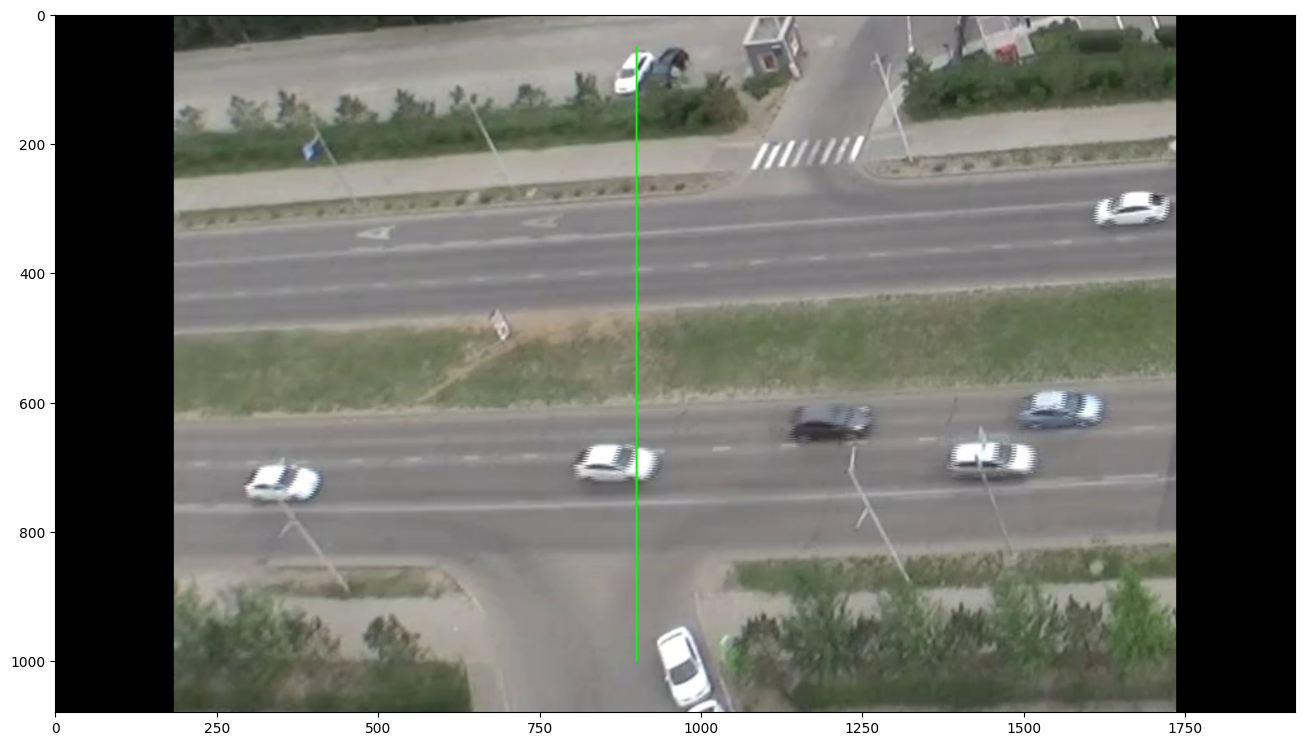

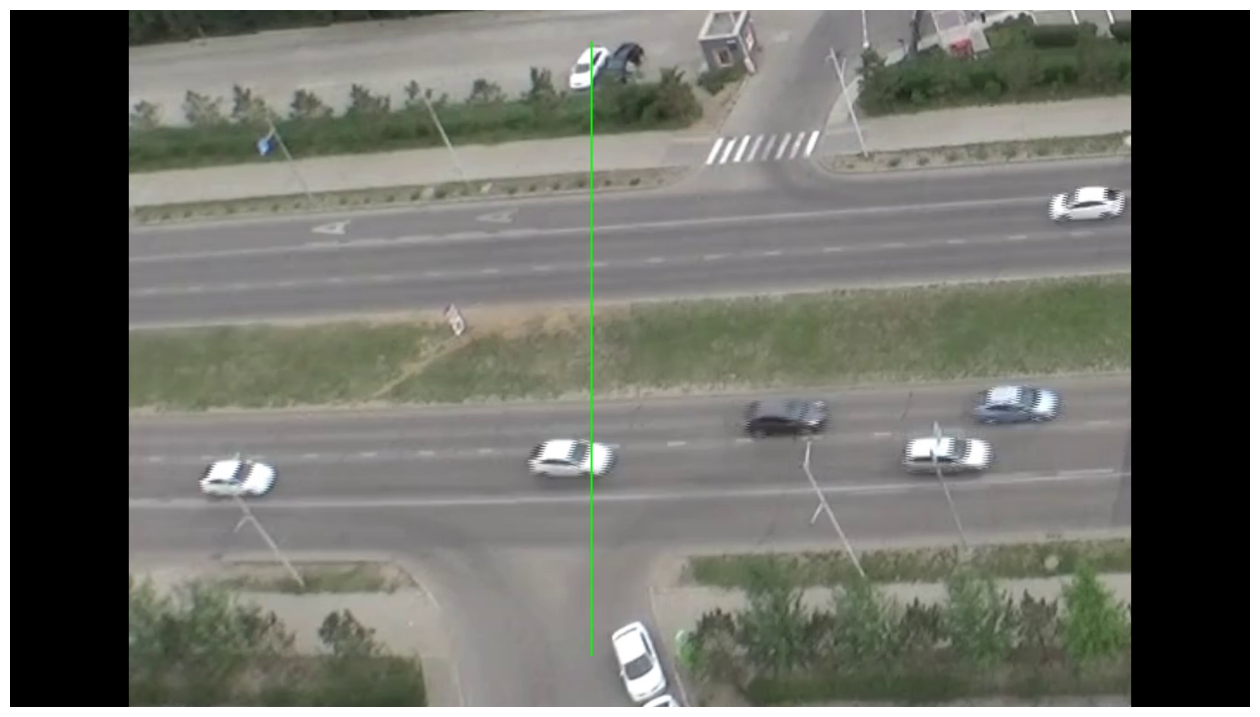

In [ ]:
# settings
import cv2
import numpy as np
import matplotlib.pyplot as plt
#LINE_START = sv.Point(150, 550)
#LINE_END = sv.Point(150, 950)
LINE_START = sv.Point(900, 50)
LINE_END = sv.Point(900, 1000)
cv2.line(anotated_frame, (LINE_START.x, LINE_START.y), (LINE_END.x, LINE_END.y), (0,255,0), 2)
%matplotlib inline
# Now plot the image using Matplotlib and display axes
plt.figure(figsize=(16, 16))  # Create a plot with a 16x16 inch size

# Convert BGR to RGB since OpenCV uses BGR and Matplotlib uses RGB
anotated_frame_rgb = cv2.cvtColor(anotated_frame, cv2.COLOR_BGR2RGB)

# Plot the image with axes
plt.imshow(anotated_frame_rgb)  # Display the image
sv.plot_image(anotated_frame, (16,16))
#TARGET_VIDEO_PATH = f"{HOME}/"

In [ ]:
result = "_result"
#result = "_bus_result"

# Get the directory and file name from the source video path
directory, file_name = os.path.split(SOURCE_VIDEO_PATH)

# Split the file name into the name and extension
file_name_without_ext, file_extension = os.path.splitext(file_name)

# Combine them to form the target video path
TARGET_VIDEO_PATH = os.path.join(directory, f"{file_name_without_ext}{result}{file_extension}")
print(TARGET_VIDEO_PATH)

/content/drive/MyDrive/cropped 21_bus_result.mp4


In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=40914)

In [ ]:
import cv2
# create BYTETracker instance
byte_tracker = sv.ByteTrack(frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
bus_line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
print(dir(line_zone))
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=3)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=3, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)

    # update line counter
    line_zone.trigger(detections)
     # Separate logic for bus counting
    #bus_detections = detections[detections.class_id == 1]
    #bus_line_zone.trigger(bus_detections)

    # Annotate frame with line counters (general and buses)
   # annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
    #annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=bus_line_zone)

    # Use in_count and out_count to show the total count
    total_in = line_zone.in_count
    total_out = line_zone.out_count
    counter_text = f"In Count: {total_in} | Out Count: {total_out}"

    # Custom text position
    position = (150, 100)  # (x, y) position to display the counter
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    color = (255, 255, 255)  # White text
    thickness = 3

    # Draw the custom counter text on the frame
    cv2.putText(annotated_frame, counter_text, position, font, font_scale, color, thickness)
    cv2.line(annotated_frame, (LINE_START.x, LINE_START.y), (LINE_END.x, LINE_END.y), (0,255,0), 2)
    # return frame with box and line annotated result
    return  annotated_frame

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_in_count_per_class', '_out_count_per_class', 'calculate_region_of_interest_limits', 'class_id_to_name', 'in_count', 'in_count_per_class', 'is_point_in_limits', 'limits', 'out_count', 'out_count_per_class', 'tracker_state', 'trigger', 'triggering_anchors', 'vector']


# **RESULT**
You can watch one of the results accessing a link below
https://drive.google.com/file/d/1FVzxDRMRhYcM1dllcbAVCumm1yZL_K4j/view?usp=drive_link